<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute predictions on a TF dataset using an stored .h5 model

In [1]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [2]:
import numpy as np
import tensorflow as tf
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
# from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from enum import Enum

In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

Tensorflow version = 2.2.0
Executing eagerly = True


In [4]:
#%cd /content/drive/My\ Drive/Healthcare/Radioterapia/data/ciolaplata
#!unrar x /content/drive/My\ Drive/Healthcare/Radioterapia/Mapas\ CIO\ La\ Plata/Mapas\ Calculados/2019.rar
#!ls -l 2015/*dcm | wc -l

if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    %cd -q '/content/fluence_maps'

    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

In [5]:
from util.dataset import _tfrecord_dataset_type_from_folder, _parse_jpeg_image_function
from util.preprocess import rescale_0_to_1

In [6]:
class CNN(Enum):
        vgg16 = 1
        resnet18 = 2
        resnet34 = 3
        mobilenetV2 = 4

In [7]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_RANDOM_SEED=23456
ARG_TFDATASET_FOLDER=f'tfds.2019-2017.localnorm.DS10%.{ARG_RANDOM_SEED}.fold0'
# ARG_MODEL_NAME = '1612063529' # VGG16 20 de enero 2021
ARG_MODEL_NAME = f'1612639030.resnet34.{ARG_RANDOM_SEED}' # ene-31 ResNet18 buen(sobre) ajuste en training.
# ARG_MODEL_NAME = '1611181684' # ResNet 18 20 de enero 2021
ARG_NETWORK=CNN.resnet34
PART_TRAIN = 'train'
PART_VALIDATION = 'validation'
PART_TEST = 'test'
PART_TO_USE = PART_VALIDATION
BATCH_SIZE = 32 # mae puede variar según batch size.
num_workers = 8
ARG_TRANSFORM_GAMMA=False

In [8]:
# hacer visiable la GPU 1050 Ti, TF v1.10 pide TF_MIN_GPU_MULTIPROCESSOR_COUNT >= 8
os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "6"
# usar la GeForce GTX 1080 Ti
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
# Con 0 usa GeForce GTX 1050 Ti
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [9]:
def getMapDatasetForPartition(part, img_size=256):
    tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
    raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, part)
    print(raw_test)

    # Apply this function to each item in the dataset using the map method:
    normalization_fn = rescale_0_to_1
    test = raw_test.map(lambda e: _parse_jpeg_image_function(e, img_size, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA), num_parallel_calls=num_workers)
    
    gamma_values = test.map(lambda image, gamma, filename: gamma)
    gamma_values = np.array(list(gamma_values.as_numpy_iterator()))
    gamma_values[:20]
    
    return test

In [10]:
IMG_SIZE=256
if ARG_NETWORK == CNN.mobilenetV2:
    IMG_SIZE=224
map_dataset = getMapDatasetForPartition(PART_TO_USE, IMG_SIZE)
print(map_dataset)
print(map_dataset.batch(BATCH_SIZE))

<TFRecordDatasetV2 shapes: (), types: tf.string>
<ParallelMapDataset shapes: ((256, 256, 3), (), ()), types: (tf.float32, tf.float32, tf.string)>
<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


In [11]:
def getBatchesForPartition(test, part):
    test_batches = test.batch(BATCH_SIZE)
    print(test_batches)

    tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
    
    return tmp_test_batches

In [12]:
# load model
dir = os.path.join(ARG_DATASET_DIR, "models")
saved_model_dir = '{}/{}.h5'.format(dir, ARG_MODEL_NAME)
print(f'Loading model {saved_model_dir}...')
loaded_model = tf.keras.models.load_model(saved_model_dir)

Loading model /hdd/data/radioterapia/ciolaplata/models/1612639030.resnet34.23456.h5...


In [13]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [14]:
tmp_test_batches = getBatchesForPartition(map_dataset, PART_TO_USE)
print(tmp_test_batches)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


In [15]:
def evaluatePartition(tmp_batches, part):
    # Evaluate dataset with the loaded model to calculate loss (mae) because
    # metric value could differ from the one reported during training.
    loss, mse = loaded_model.evaluate(tmp_batches, workers=num_workers, verbose=0)
    print('Loaded model, {} loss: {:5.4f}'.format(part, loss))
    print('Loaded model, {} mse: {:5.4f}\n'.format(part, mse))

In [16]:
evaluatePartition(tmp_test_batches, PART_TO_USE)

Loaded model, validation loss: 1.6927
Loaded model, validation mse: 7.5598



In [17]:
def getPredictionsDataframe(test, part):
    tmp_batches = getBatchesForPartition(test, part)
    # Make predictions
    predictions = loaded_model.predict(tmp_batches)
    # from (1121,1) to (1121,); ie.: ndim = 2 to ndim = 1
    predictions = predictions.reshape(-1)
    predictions.shape

    tmp_test_dataset = test.map(lambda image, gamma, filename: (filename, gamma))
    print(tmp_test_dataset)

    lst = [(filename.numpy().decode('utf-8'), gamma.numpy()) for filename, gamma in tmp_test_dataset]
    lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

    # armar un pandas dataframe con el test set completo
    df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
    dir = os.path.join(ARG_DATASET_DIR, "predictions")
    predictions_file_path = '{}/predicted_gamma_{}.{}.csv'.format(dir, ARG_MODEL_NAME, part)
    df.to_csv(predictions_file_path, index=False)
    print(f'Predictions saved to {predictions_file_path}.\n')
    
    return df

In [18]:
df = getPredictionsDataframe(map_dataset, PART_TO_USE)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((), ()), types: (tf.string, tf.float32)>
Predictions saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1612639030.resnet34.23456.validation.csv.



In [19]:
def display_scatterplot(model_name, part, y, y_hat):
    print('Model name = %s' % model_name)
    print(f'Dataset = {ARG_TFDATASET_FOLDER}')
    print('size = %d' % len(y))

    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE on %s = %.3f' % (part, mae))

    # mean square error
    mse = mean_squared_error(y, y_hat)
    print('MSE on %s = %.3f' % (part, mse))
    
    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Pearson correlation in %s = %.3f' % (part, corr))

    r2score = r2_score(y, y_hat)
    print('R-squared in %s = %.3f' % (part, r2score))
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted (%s)' % part)
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    ax.plot([minimum+3, 100], [minimum, 97], ls="--", c=".4")
    ax.plot([minimum, 97], [minimum+3, 100], ls="--", c=".4")
    plt.show()

Model name = 1612639030.resnet34.23456
Dataset = tfds.2019-2017.localnorm.DS10%.23456.fold0
size = 854
MAE on validation = 1.693
MSE on validation = 7.560
Pearson correlation in validation = 0.817
R-squared in validation = 0.665


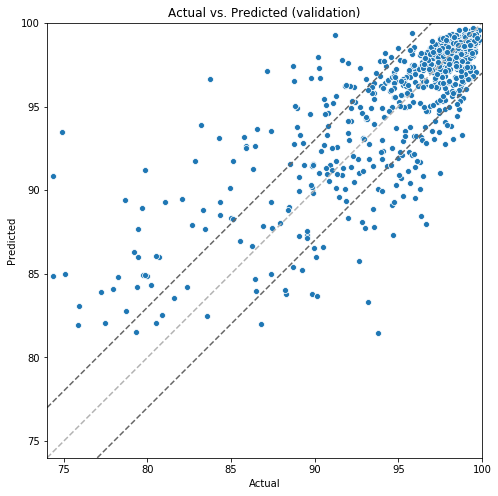

<Figure size 1080x1080 with 0 Axes>

In [20]:
y = df['actual gamma']
y_hat = df['predicted gamma']
display_scatterplot(ARG_MODEL_NAME,PART_TO_USE, y, y_hat)

In [21]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')